## Setup

### Load packages

In [1]:
suppressPackageStartupMessages({
library(ggplot2)
library(dplyr)
library(statsr)
library(BAS)
library(MASS)
library(broom)
library(GGally)
library(gridExtra)
})

### Load data

Make sure your data and R Markdown files are in the same directory. When loaded
your data file will be called `movies`. Delete this note when before you submit 
your work. 

In [2]:
load("movies.Rdata")

Before moving further, we'll set the seed to be used later in case of random sampling or other random processes.

In [3]:
set.seed(18382)

## Part 1: Data

The dataset consists of 651 randomly sampled movies. Based on this assumption about the sampling, we can accept the generalization of the inferences done during the current study. Since movies are randomly sampled, there are no bias caused by `genre`, `actors`, `studio` among others. We will also assume that the samples are independent between each other, which is also quite plausible considering the sample randomness.

Causality **cannot be inferred** from this dataset since the data has been obtained without random assignment of confouding variables.

### A Quick Look to the Dataset

Let's take a first look at the dataset that will be used for the Explanatory Data Analysis (EDA) and the following modeling. We will start having a look at the first observations. As it can also be observed, the dataset consists of 651 observations and 32 features.

In [4]:
dim(movies)
head(movies,5)

[1] 651  32

title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,dvd_rel_year,⋯,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Filly Brown,Feature Film,Drama,80,R,Indomina Media Inc.,2013,4,19,2013,⋯,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
The Dish,Feature Film,Drama,101,PG-13,Warner Bros. Pictures,2001,3,14,2001,⋯,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
Waiting for Guffman,Feature Film,Comedy,84,R,Sony Pictures Classics,1996,8,21,2001,⋯,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
The Age of Innocence,Feature Film,Drama,139,PG,Columbia Pictures,1993,10,1,2001,⋯,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
Malevolence,Feature Film,Horror,90,R,Anchor Bay Entertainment,2004,9,10,2005,⋯,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/


In [5]:
str(movies)

tibble [651 × 32] (S3: tbl_df/tbl/data.frame)
 $ title           : chr [1:651] "Filly Brown" "The Dish" "Waiting for Guffman" "The Age of Innocence" ...
 $ title_type      : Factor w/ 3 levels "Documentary",..: 2 2 2 2 2 1 2 2 1 2 ...
 $ genre           : Factor w/ 11 levels "Action & Adventure",..: 6 6 4 6 7 5 6 6 5 6 ...
 $ runtime         : num [1:651] 80 101 84 139 90 78 142 93 88 119 ...
 $ mpaa_rating     : Factor w/ 6 levels "G","NC-17","PG",..: 5 4 5 3 5 6 4 5 6 6 ...
 $ studio          : Factor w/ 211 levels "20th Century Fox",..: 91 202 167 34 13 163 147 118 88 84 ...
 $ thtr_rel_year   : num [1:651] 2013 2001 1996 1993 2004 ...
 $ thtr_rel_month  : num [1:651] 4 3 8 10 9 1 1 11 9 3 ...
 $ thtr_rel_day    : num [1:651] 19 14 21 1 10 15 1 8 7 2 ...
 $ dvd_rel_year    : num [1:651] 2013 2001 2001 2001 2005 ...
 $ dvd_rel_month   : num [1:651] 7 8 8 11 4 4 2 3 1 8 ...
 $ dvd_rel_day     : num [1:651] 30 28 21 6 19 20 18 2 21 14 ...
 $ imdb_rating     : num [1:651] 5.5 7.3 7.6 7.

## Part 2: Data manipulation

We will feature engineer some variables that will be later used to generate the model. The features that will be generated are:
- feature_film: Describes whether the film is cataloged by the industry as a `feature film`. Typically are films with a length in the interval $[75;210]$ minutes.
- drama: If the movie is a drama
- mpaa_rating_R: Whether the movie is classified as an `R` movie.
- oscar_season: If the movie was released in the `oscar` season: Oct, Nov or Dec.
- summer_season: If the movie was released during the summer season: May, June, Jul, Aug.

After adding the new features to the dataset, several others will be cleaned so they can later be used easily during the modeling phase.

In [6]:
movies_ext <- movies %>%
    mutate(feature_film = ifelse((runtime > 75 & runtime < 210), "yes", "no")) %>%
    mutate(drama = ifelse((genre=="Drama"), "yes", "no")) %>%
    mutate(mpaa_rating_R = ifelse((mpaa_rating=="R"), "yes", "no")) %>%
    mutate(oscar_season = ifelse((thtr_rel_month > 9), "yes", "no")) %>%
    mutate(summer_season = ifelse((thtr_rel_month > 4 & thtr_rel_month < 9), "yes", "no"))

Now let's clean the whole dataset

In [7]:
movies_ext <- movies_ext %>%
        filter(!is.na(thtr_rel_year),!is.na(runtime), !is.na(imdb_rating),
               !is.na(critics_score), !is.na(audience_score), !is.na(title_type),
               !is.na(genre), !is.na(mpaa_rating), !is.na(studio), !is.na(dvd_rel_year),
               !is.na(best_pic_nom), !is.na(best_actor_win), !is.na(best_actress_win), 
               !is.na(best_dir_win), !is.na(top200_box))

dim(movies_ext)
head(movies_ext)

[1] 634  37

title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,dvd_rel_year,⋯,actor3,actor4,actor5,imdb_url,rt_url,feature_film,drama,mpaa_rating_R,oscar_season,summer_season
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Filly Brown,Feature Film,Drama,80,R,Indomina Media Inc.,2013,4,19,2013,⋯,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/,yes,yes,yes,no,no
The Dish,Feature Film,Drama,101,PG-13,Warner Bros. Pictures,2001,3,14,2001,⋯,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/,yes,yes,no,no,no
Waiting for Guffman,Feature Film,Comedy,84,R,Sony Pictures Classics,1996,8,21,2001,⋯,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/,yes,no,yes,no,yes
The Age of Innocence,Feature Film,Drama,139,PG,Columbia Pictures,1993,10,1,2001,⋯,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/,yes,yes,no,yes,no
Malevolence,Feature Film,Horror,90,R,Anchor Bay Entertainment,2004,9,10,2005,⋯,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/,yes,no,yes,no,no
Old Partner,Documentary,Documentary,78,Unrated,Shcalo Media Group,2009,1,15,2010,⋯,Moo,NA,NA,http://www.imdb.com/title/tt1334549/,//www.rottentomatoes.com/m/old-partner/,yes,no,no,no,no


## Part 3: Exploratory data analysis

Now that the dataset is ready to use, we can start visualizing some variables from the dataset to estimate their relationship with the target variable.

### Plots

Using some plots, we can detect collinear variables, place the data in a scatterplot to analyze -at least preliminary- the features distribution vs. our target variable.

R has an excellent function  to tackle this task: `ggpairs`.

In [8]:
# Adjust plots size
options(repr.plot.width=10, repr.plot.height=8)

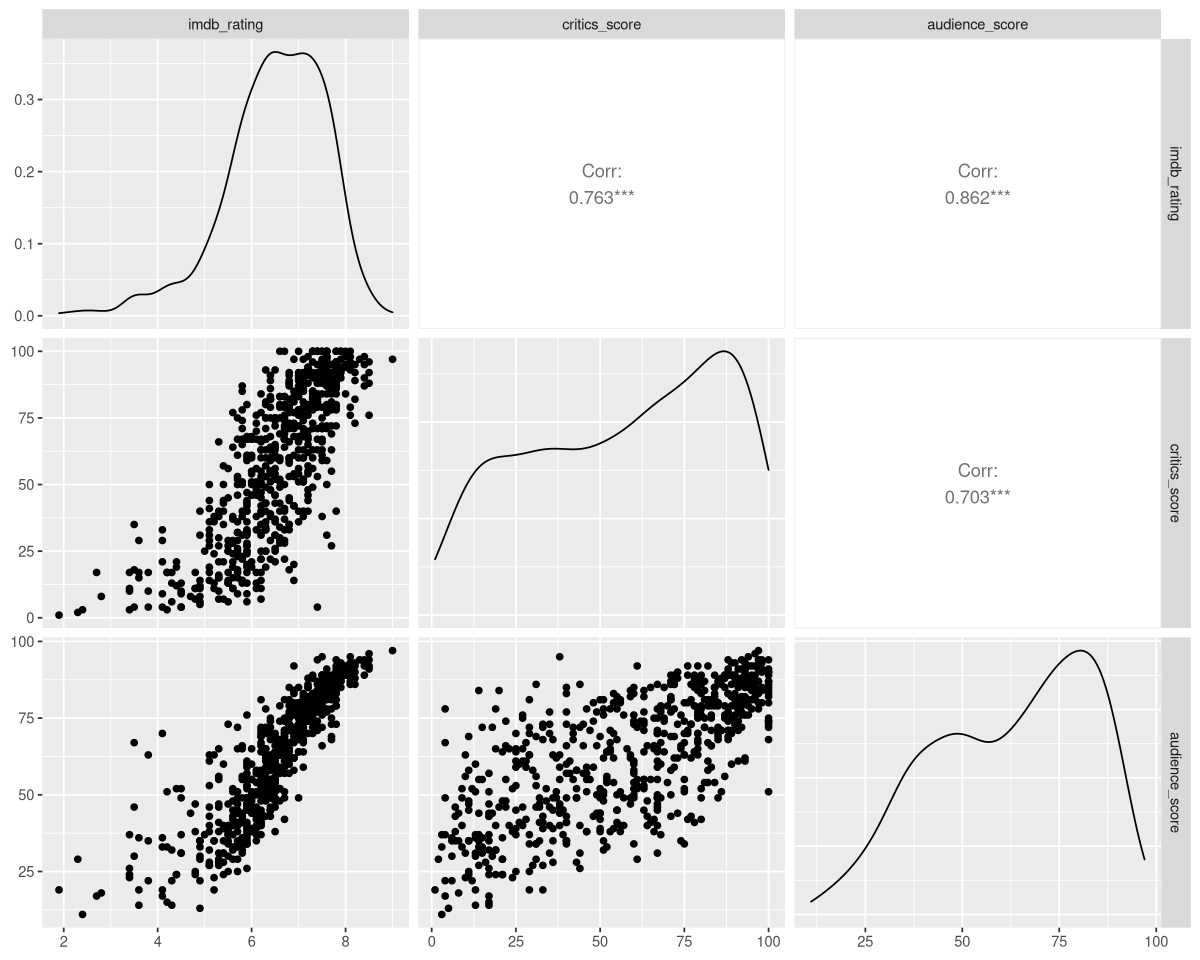

In [9]:
movies_ext %>%
    ggpairs(columns=c('imdb_rating', 'critics_score', 'audience_score'))

There are 3 features in the dataset linked with movie scores:
- imdb rating
- critics score (from Rotten Tomatoes)
- audience score (our target variable)

The first thing to notice the high collinearity. Hence, we should only pick one of them as a predictor and take out the rest. Also notice that `critics mean` has less dispersion, and at the same time is collinear with the other two variables. Naturally is highly collinear with `critics_score`.

Does the runtime or the film rating has something to do with the audience score? Let's check it out.

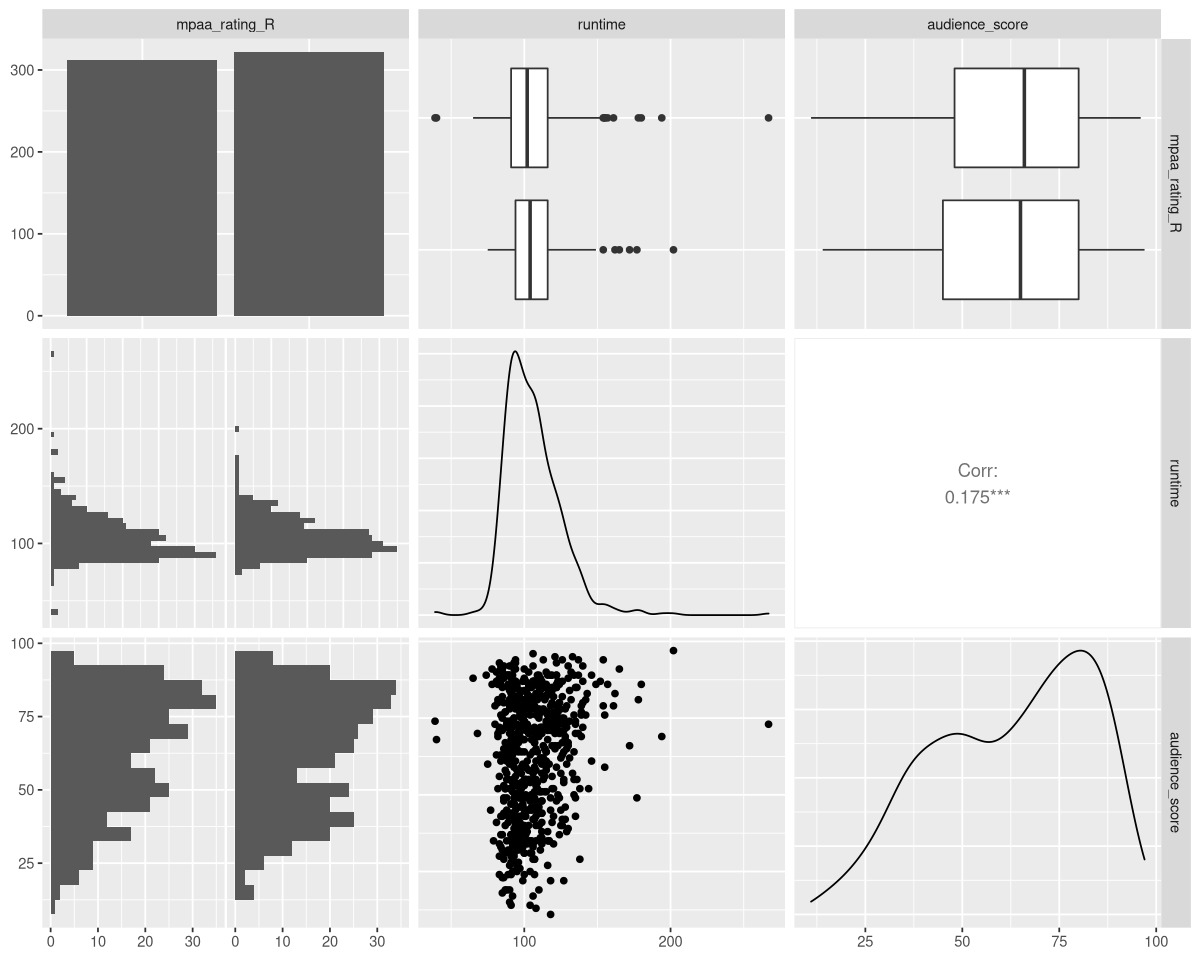

In [10]:
movies_ext %>%
    ggpairs(columns=c('mpaa_rating_R', 'runtime', 'audience_score'), 
            lower = list(combo = wrap(ggally_facethist, binwidth = 5)))

Comparing this variables with `audience_score`, we can determine the following:
- `mpaa_rating_R` is well balanced among films that can be found in the dataset. From the boxplots, the boxes seems quite similar between classes, with a median value similar in each of them. There is no much variance difference between them. Hence at a glance, is impossible to determine significant differences between them.
- The correlation between audience_score and runtime is not that high. At the same time, the distribution of runtime seems to be normally distributed. Given the correlation value, this is a feature that we shouldn't pick in a first try in case we have better options.

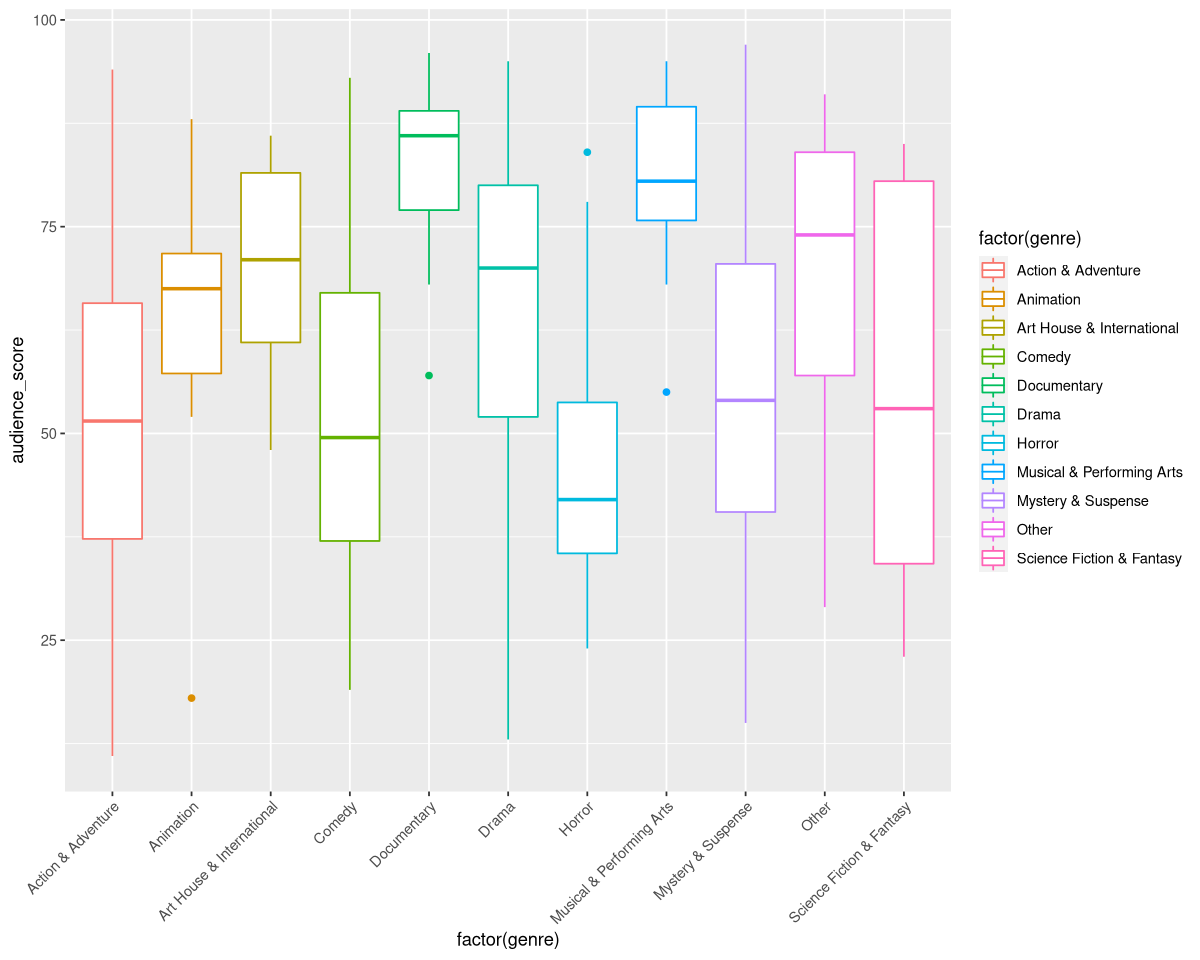

In [11]:
ggplot(movies_ext, aes(x=factor(genre), y=audience_score, colour=factor(genre))) +
        geom_boxplot() + theme(axis.text.x = element_text(angle=45, hjust=1))

Clearly, there are genres better scored than others, even without an `ANOVA` test, their median differences are significant.

Surprisingly, Documentary films rank very well with a small boxplot indicating low scoring dispersion. Also, Musical & Performing Arts ranks quite high. We'll see later how the weights of the MLR model weighs the genres in particular.

Let's take a look now to other predictor, which somehow might be linked to the movie score. The `top200_box` tells whether the movie is in the Top 200 Box Office list. This is a natural classifier and we should expect that those listed in this ranking score better.

### Summary Statistics

Let's execute some summary statistics in our target variable to understand it a bit more.

In [12]:
summary(movies_ext$audience_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.00   46.00   65.00   62.59   80.00   97.00 

The distribution is slightly left skewed and centered above the half scale. Most of the scores are distributed between 46 and 80.

Now let's take a look at the distribution of the whole predictors, notice that not all of them are numerical but they are rather distributed between numerical and categorical classes. As mentioned before, not all the predictors will be in the final model due to lack of predicting power. In any case, the multiple linear regression model algorithm will take charge of selecting the best feature candidates to have the most accurate model possible with these features universe.

In [13]:
summary(movies_ext)

    title                  title_type                 genre        runtime     
 Length:634         Documentary : 51   Drama             :301   Min.   : 39.0  
 Class :character   Feature Film:579   Comedy            : 86   1st Qu.: 93.0  
 Mode  :character   TV Movie    :  4   Action & Adventure: 62   Median :103.0  
                                       Mystery & Suspense: 59   Mean   :106.1  
                                       Documentary       : 49   3rd Qu.:116.0  
                                       Horror            : 22   Max.   :267.0  
                                       (Other)           : 55                  
  mpaa_rating                               studio    thtr_rel_year 
 G      : 17   Paramount Pictures              : 37   Min.   :1972  
 NC-17  :  1   Warner Bros. Pictures           : 30   1st Qu.:1991  
 PG     :114   Sony Pictures Home Entertainment: 27   Median :2000  
 PG-13  :132   Universal Pictures              : 23   Mean   :1998  
 R      :322   

### EDA Observations
Let's briefly recap the work done so far. We can state that:

- There are several collinear variables we have to take care to avoid a biased model.
- We've found some features which will be clearly removed from the modelling due to the lack of predictability.
- Genres look promising as an estimator of the audience score, as we've seen.


Let's see what features are selected using a Bayesian Information Criteria (BIC) approach. In this way, the algorithm iterates over the model, removing the non-significant features one at a time. This is done looking at the BIC result after evaluating the model. 

## Part 4: Modeling

The task is to develop a Bayesian regression model to predict `audience_score` from the following
explanatory variables. We'll start by first selecting the following predictors from the full dataset.

- `feature_film`
- `drama`
- `runtime`
- `mpaa_rating_R`
- `thtr_rel_year`
- `oscar_season`
- `summer_season`
- `imdb_rating`
- `imdb_num_votes`
- `critics_score`
- `best_pic_nom`
- `best_pic_win`
- `best_actor_win`
- `best_actress_win`
- `best_dir_win`
- `top200_box`


In [14]:
movies_mdl <- movies_ext %>%
    dplyr::select(feature_film, drama, runtime, mpaa_rating_R, thtr_rel_year,
        oscar_season, summer_season, imdb_rating, imdb_num_votes, critics_score,
        best_pic_nom, best_pic_win, best_actor_win, best_actress_win, best_dir_win,
        top200_box, audience_score)

head(movies_mdl,5)

feature_film,drama,runtime,mpaa_rating_R,thtr_rel_year,oscar_season,summer_season,imdb_rating,imdb_num_votes,critics_score,best_pic_nom,best_pic_win,best_actor_win,best_actress_win,best_dir_win,top200_box,audience_score
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
yes,yes,80,yes,2013,no,no,5.5,899,45,no,no,no,no,no,no,73
yes,yes,101,no,2001,no,no,7.3,12285,96,no,no,no,no,no,no,81
yes,no,84,yes,1996,no,yes,7.6,22381,91,no,no,no,no,no,no,91
yes,yes,139,no,1993,yes,no,7.2,35096,80,no,no,yes,no,yes,no,76
yes,no,90,yes,2004,no,no,5.1,2386,33,no,no,no,no,no,no,27


### BIC Model Selection

Let's first start by selecting the best model using the BIC criteria. The BIC is somewhat a performance factor of the model, which is computed with the model's likelihood, samples and number of features. The likelihood of the model is directly connected with the Bayes Factor, which is used to reject/accept different hypothesis. It is somehow the Bayesian analogous to the p-values.

R has a function `stepAIC` from the `MASS` package that will work backwards 
through the model space, removing variables until the AIC score can be no longer 
lowered. It takes all inputs in the full model, and a penalty parameter $k$. 
The default setting is $k=2$ for the AIC score.

We'll use the library and set `k = log(n)` to find the best model according to BIC (in which case `k = log(n)` where $n$ is the number of observations).

In [15]:
movies_model_full <- lm(audience_score ~ ., data = movies_mdl)
n <- nrow(movies_mdl)
k_BIC <- log(n)
stepAIC(movies_model_full, k=k_BIC, trace=0)


Call:
lm(formula = audience_score ~ imdb_rating + critics_score, data = movies_mdl)

Coefficients:
  (Intercept)    imdb_rating  critics_score  
    -37.02064       14.62214        0.07669  


As we can see, the parsimonious model has two predictors: `imdb_rating` and `critics_score`

### BAS Model Selection Method

Now we'll select the best model using a different criteria which have been presented in the lectures. First, we model the weights of the $2^p$ models given the $p$ predictors available. Once we have obtained the posterior probability of each model, we can make inference and obtain weighted averages of quantities of interest using these probabilities as weights. Models with higher posterior probabilities receive higher weights, while models with lower posterior probabilities receive lower weights.

Several priors can be used in this approach. We'll evaluate the results of priors based on BIC and with Zellner-Siow Cauchly. The latter approach tries to minimize the Bartlett’s/Jeffrey-Lindley’s and the information paradoxes.

In [16]:
movies_model_full <- bas.lm(audience_score ~ ., data=na.omit(movies_mdl),
                            prior="BIC", modelprior=uniform())
summary(movies_model_full)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.00000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
feature_filmyes,0.05029876,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
dramayes,0.04484561,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
runtime,0.47242603,0.0000,1.0000000,0.0000000,0.0000000,1.0000000
mpaa_rating_Ryes,0.14929055,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
thtr_rel_year,0.09080264,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
oscar_seasonyes,0.06974232,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
summer_seasonyes,0.07555007,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
imdb_rating,1.00000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
imdb_num_votes,0.05821402,0.0000,0.0000000,0.0000000,0.0000000,0.0000000


In [17]:
movies_model_full <- bas.lm(audience_score ~ ., data=na.omit(movies_mdl),
                            prior="ZS-null", modelprior=uniform())
summary(movies_model_full)

,P(B != 0 | Y),model 1,model 2,model 3,model 4,model 5
Intercept,1.00000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
feature_filmyes,0.05276570,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
dramayes,0.04776066,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
runtime,0.46768214,0.0000,1.0000000,0.0000000,0.0000000,0.0000000
mpaa_rating_Ryes,0.15338569,0.0000,0.0000000,0.0000000,0.0000000,1.0000000
thtr_rel_year,0.09543203,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
oscar_seasonyes,0.07230873,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
summer_seasonyes,0.07870998,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
imdb_rating,1.00000000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
imdb_num_votes,0.06177821,0.0000,0.0000000,0.0000000,0.0000000,0.0000000


Using the BIC and the BMA approaches, the feature selection with best prediction power leads to two of them:
- `imdb_rating`
- `critics_score`

The Zellner Sior prior has a slightly better posterior probability, hence better prediction results. Based on this discussion, we can analyze the conditions for linear regression by the evaluation of the residuals distribution, along the fitted values.

In [18]:
movies_model_BIC = lm(audience_score ~ imdb_rating + critics_score, data=movies_mdl)

### Model Selection

Based on the posterior probabilities and the number of factors, where the rule of thumb is that the less predictors with the highest predictive power is the better. We will prefer for the rest of the analysis the model with the following explanatory variables:
- `imdb_rating`
- `critics_score`

Additionally we'll be working with the model with the highest posterior probability which is also referred as the Highest Performance Model (HPM).

### Model Diagnostics

In [19]:
movies_model_hpm_aug <- augment(movies_model_BIC)

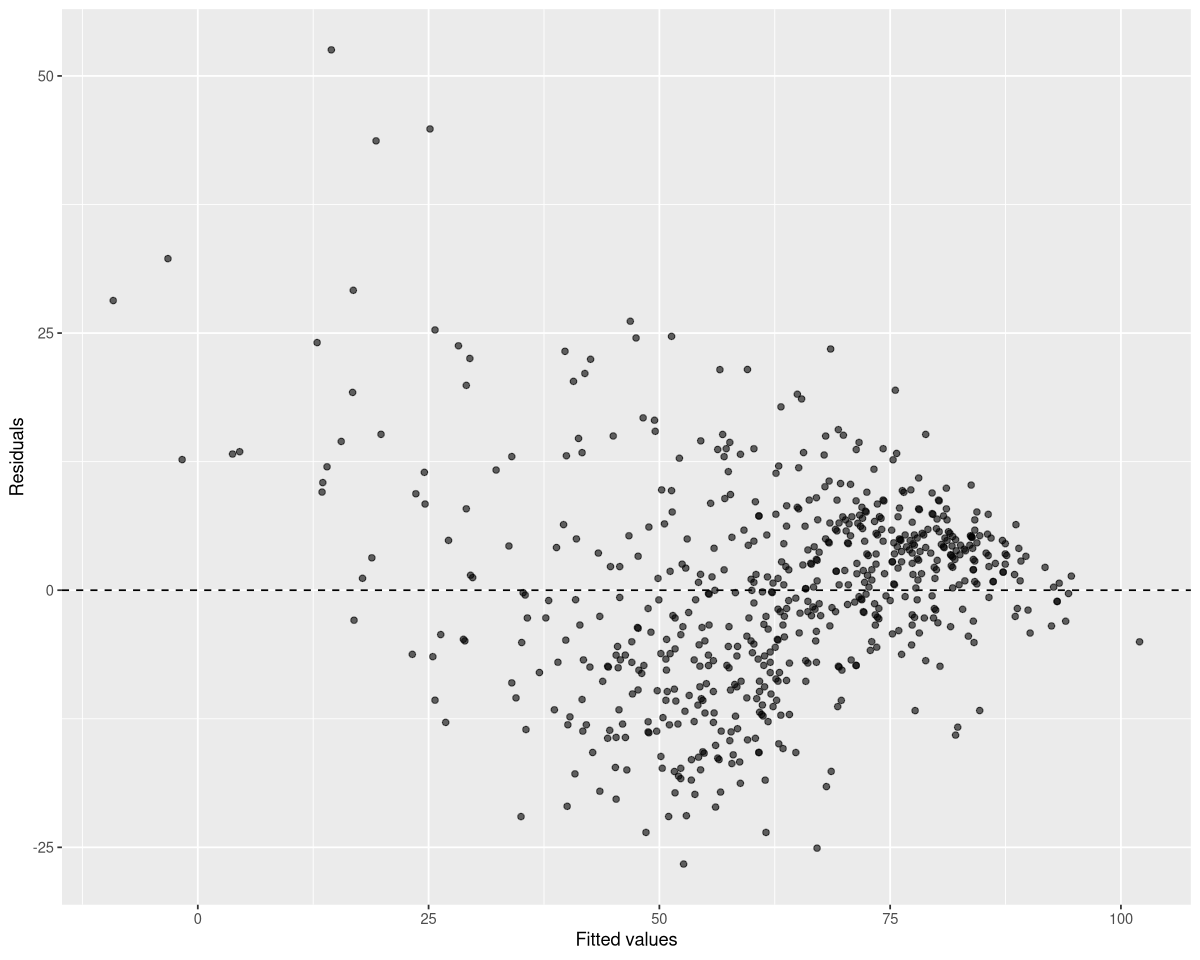

In [20]:
# Type your code for Exercise 1 here.
ggplot(data = movies_model_hpm_aug, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

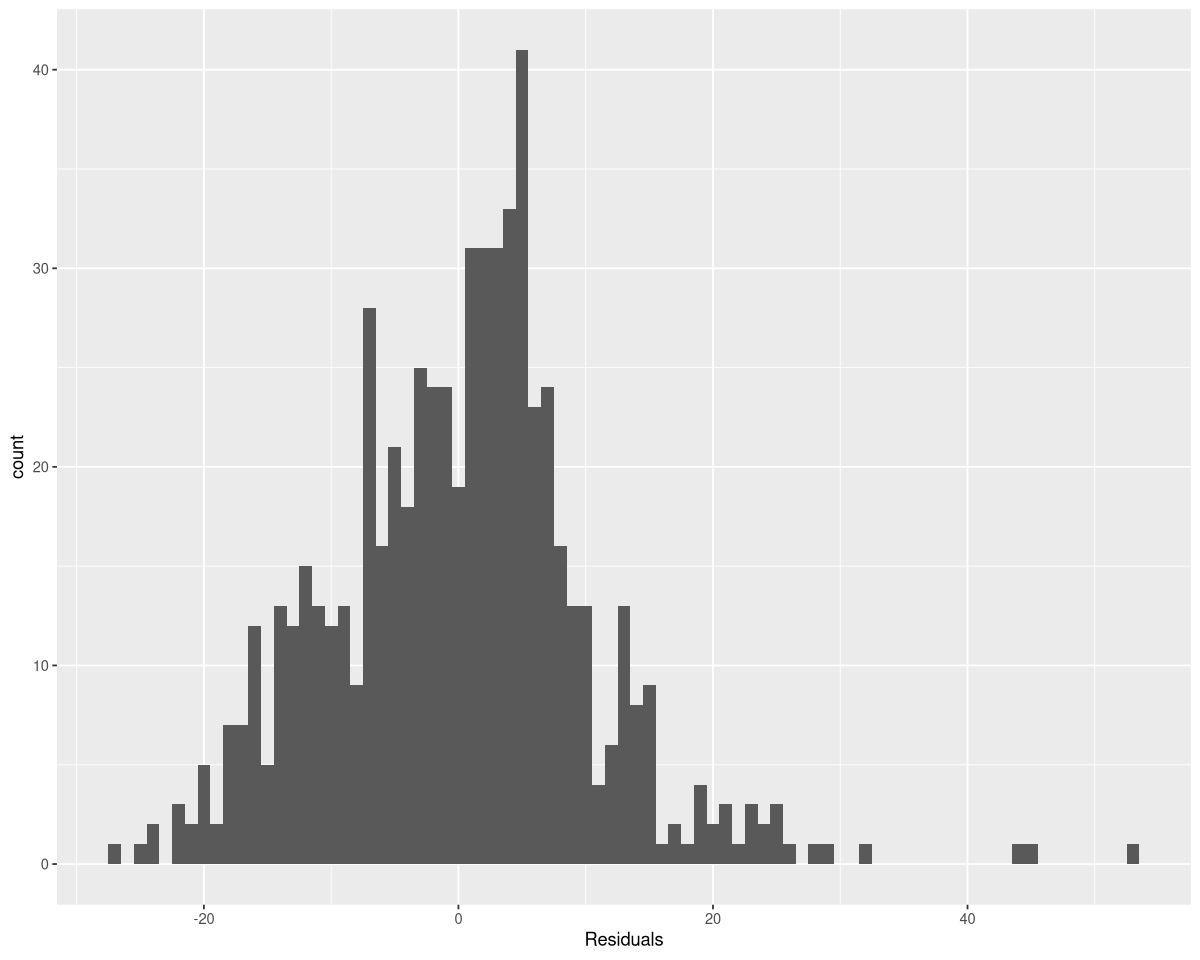

In [21]:
ggplot(data = movies_model_hpm_aug, aes(x = .resid)) +
  geom_histogram(binwidth = 1) +
  xlab("Residuals")

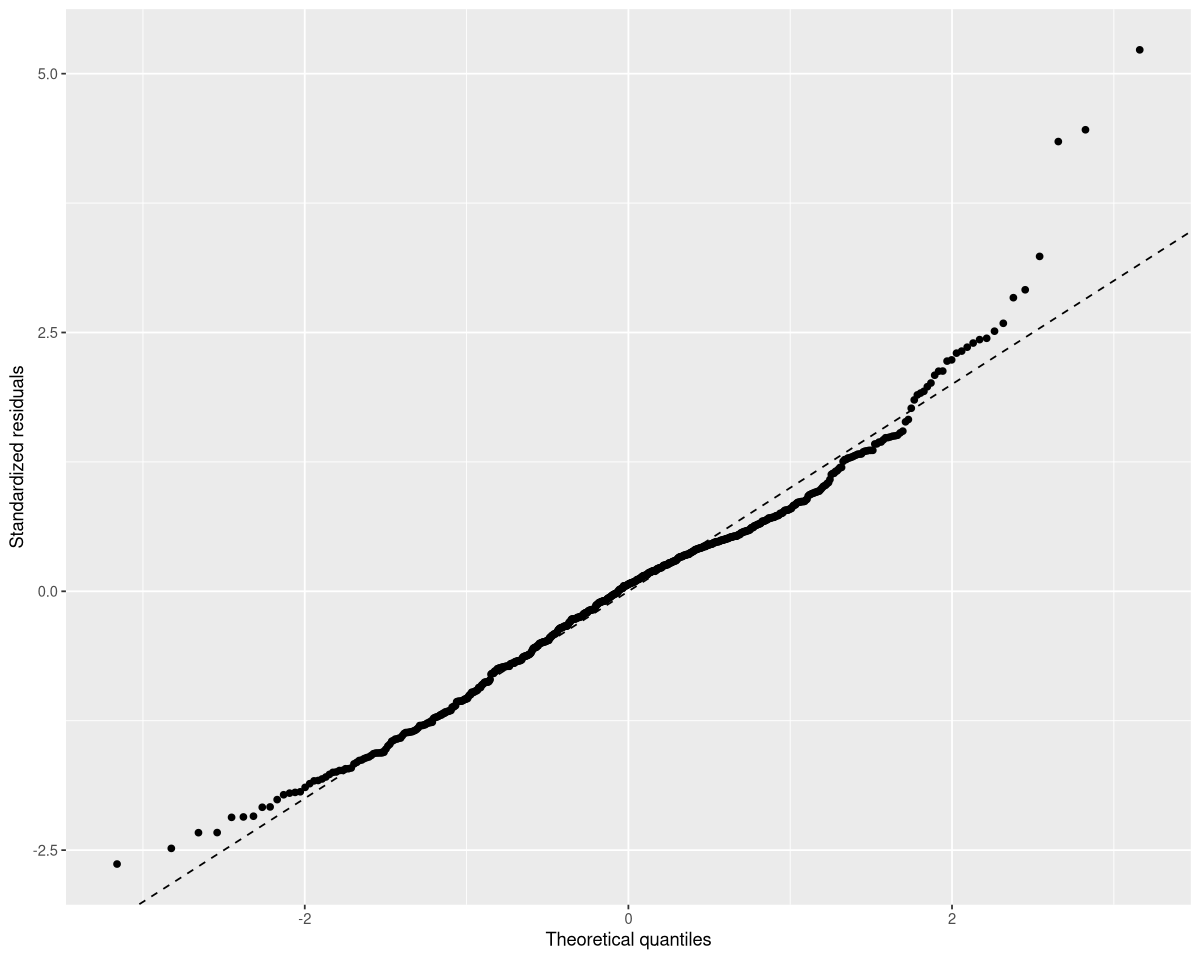

In [22]:
ggplot(movies_model_hpm_aug) +
  geom_qq(aes(sample = .std.resid)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(x = "Theoretical quantiles", y = "Standardized residuals")

From the q-q plot, it can be seen some skewness in the higher quantiles. Maybe we can reduce it applying a $log()$ function to the target variable. Let's try to solve this issue with the proposed transformation.

### Log transformation to `audience_score`

In [23]:
movies_mdl <- movies_mdl %>%
    mutate(audience_score_log = log(audience_score))

In [24]:
movies_model_BIC_log = lm(audience_score_log ~ imdb_rating + critics_score, data=na.omit(movies_mdl))
movies_model_hpm_aug_log <- augment(movies_model_BIC_log)

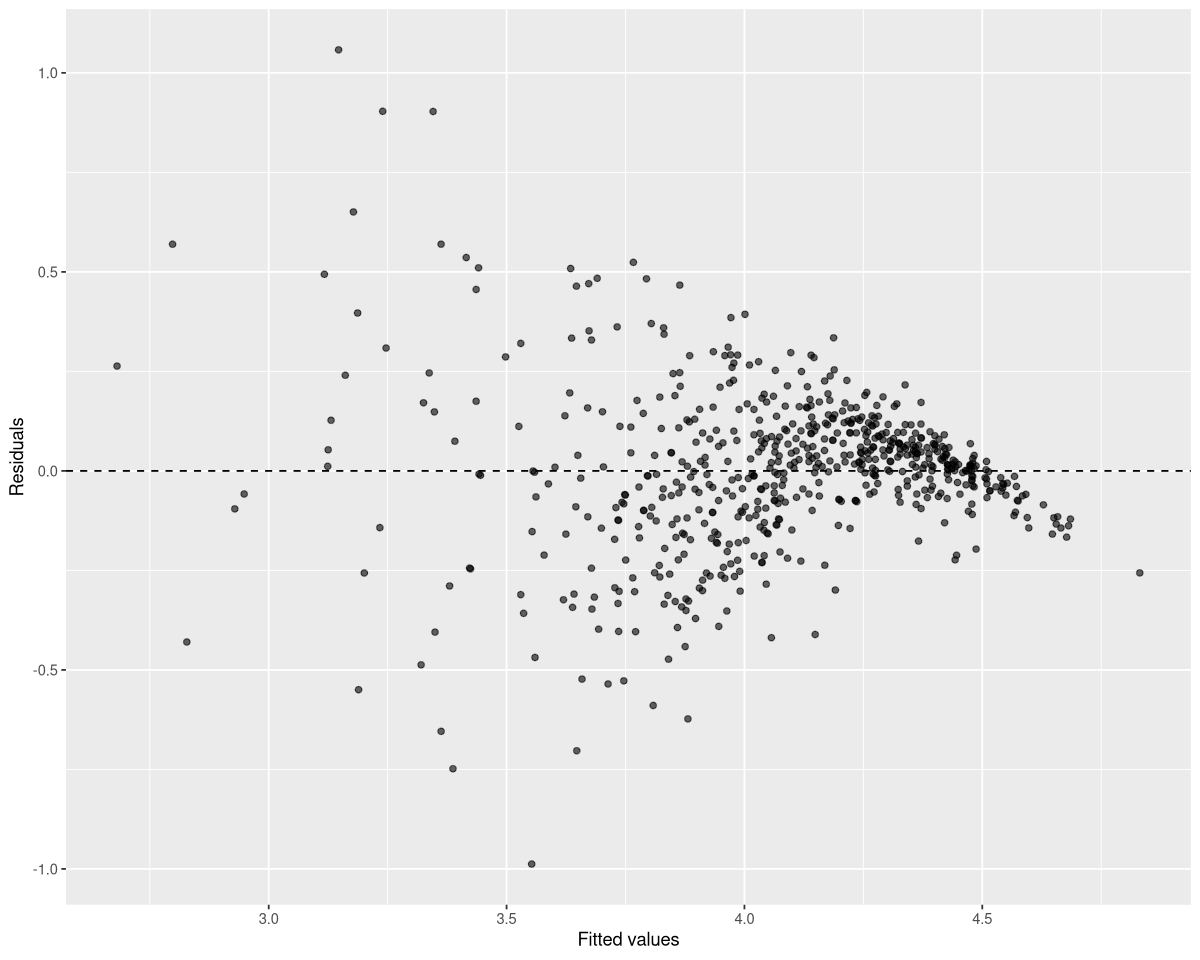

In [25]:
ggplot(data = movies_model_hpm_aug_log, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

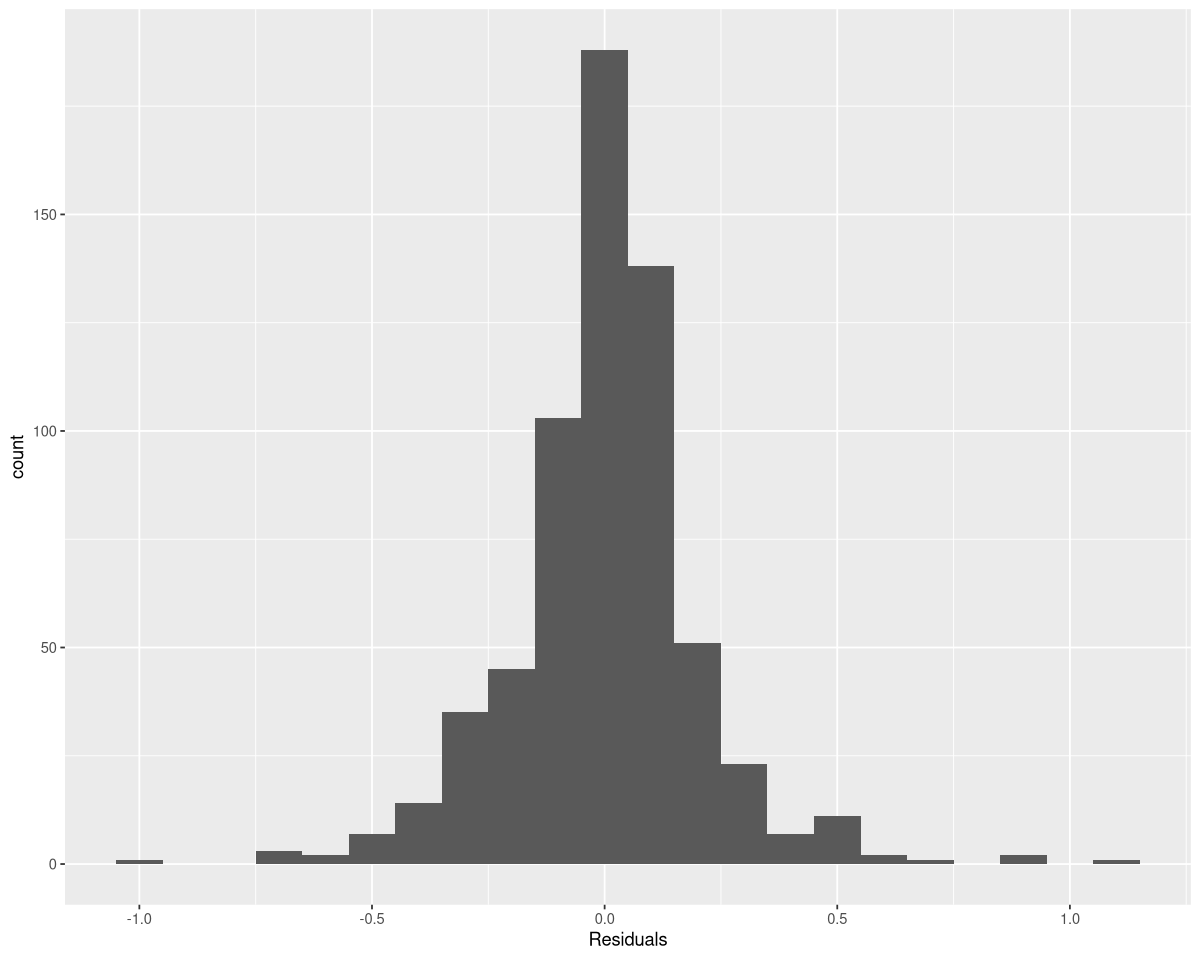

In [26]:
ggplot(data = movies_model_hpm_aug_log, aes(x = .resid)) +
  geom_histogram(binwidth = .1) +
  xlab("Residuals")

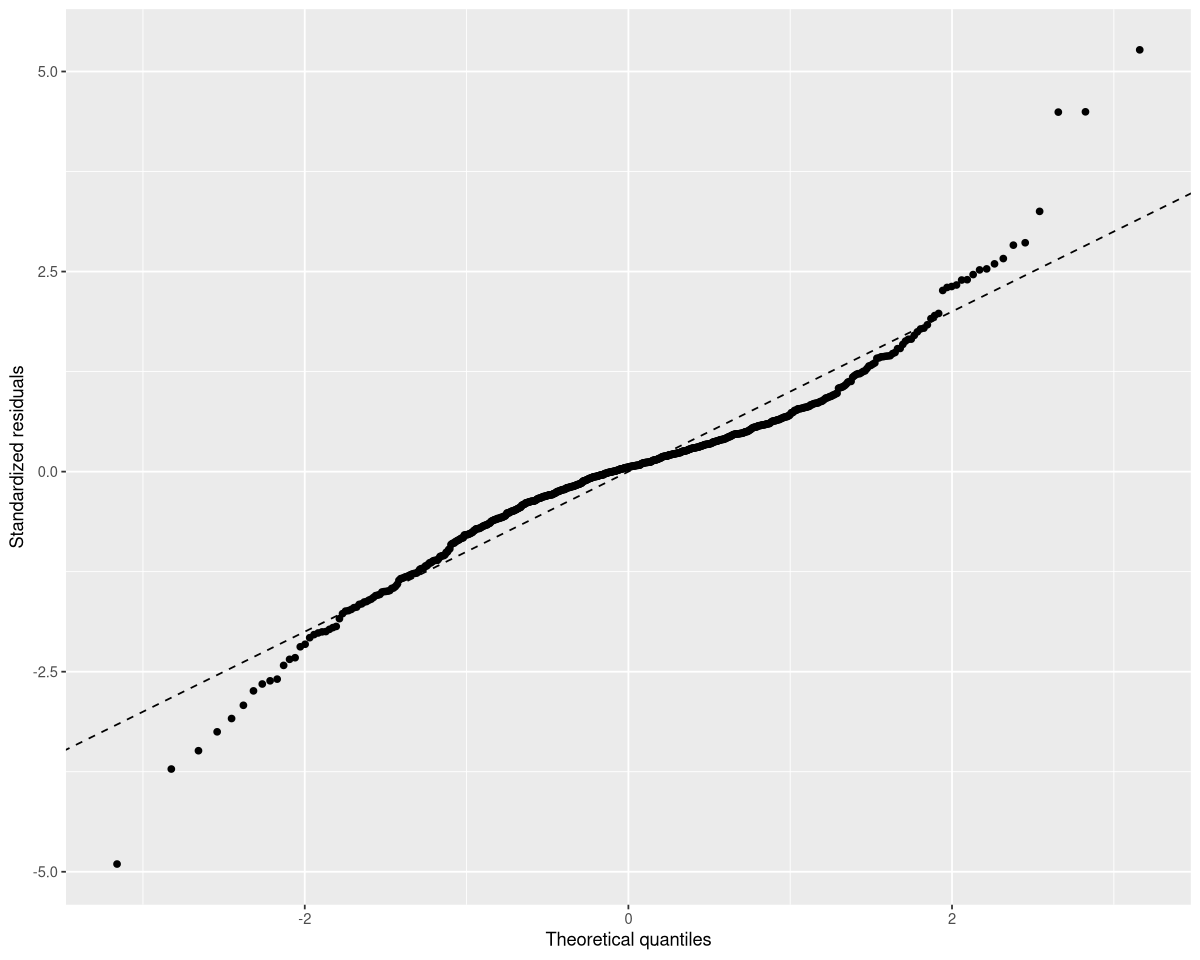

In [27]:
ggplot(movies_model_hpm_aug_log) +
  geom_qq(aes(sample = .std.resid)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  labs(x = "Theoretical quantiles", y = "Standardized residuals")

There aren't much differences in the residuals distribution, the q-q plot stills show residuals outside the dashed curve. Furthermore, the funnel shape is not fixed with the transformation. Removing the outliers from the dataset may help to obtain a better performance model. However, there might be a risk to reduce the dataset representativeness and at the same time, bias the predictions.

Given the negative outcomes, we'll carry on using the standard distribution during the rest of the study.

### Interpretation of model coefficients

Let's now analyze some critical coefficients which remained in the edge of being selected in the MLR model.

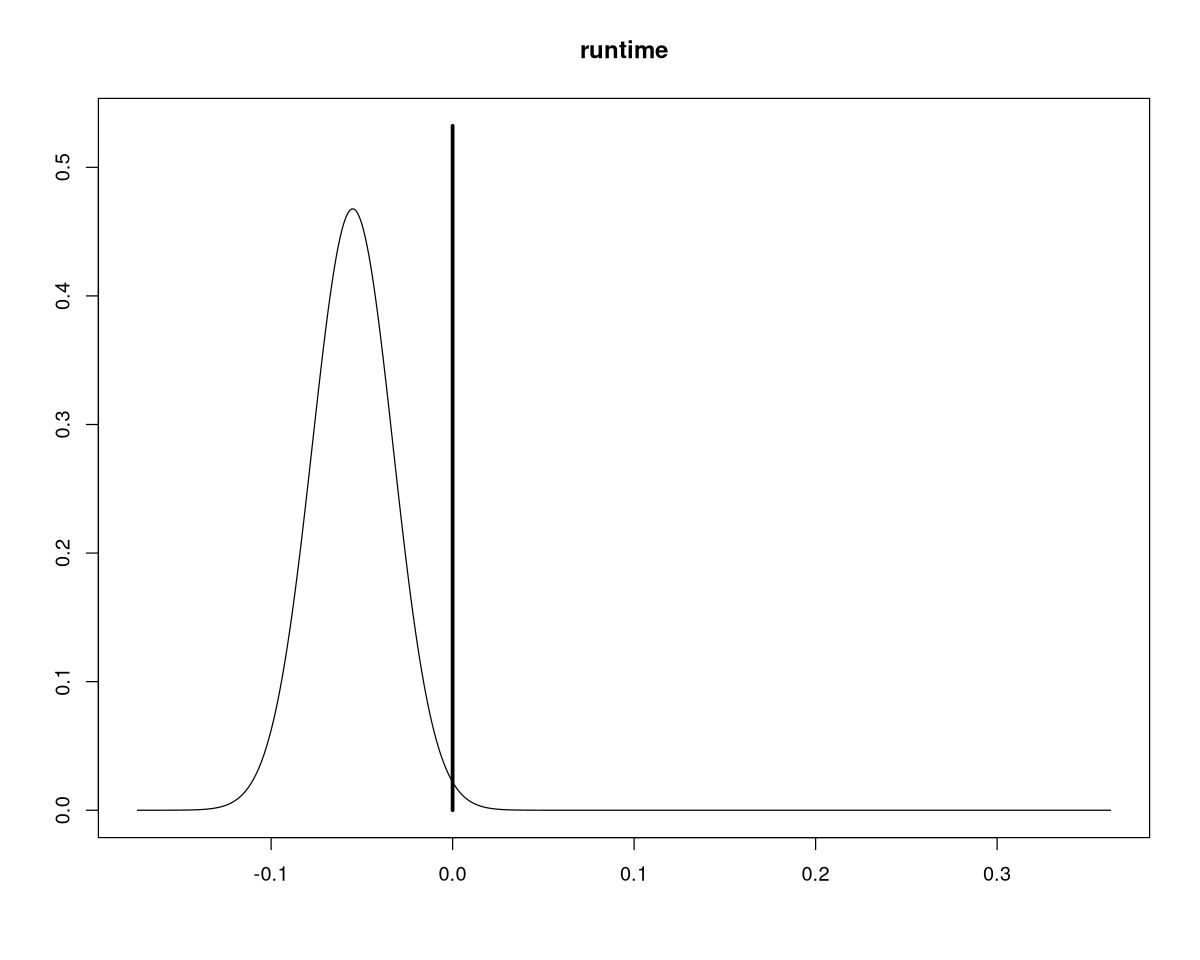

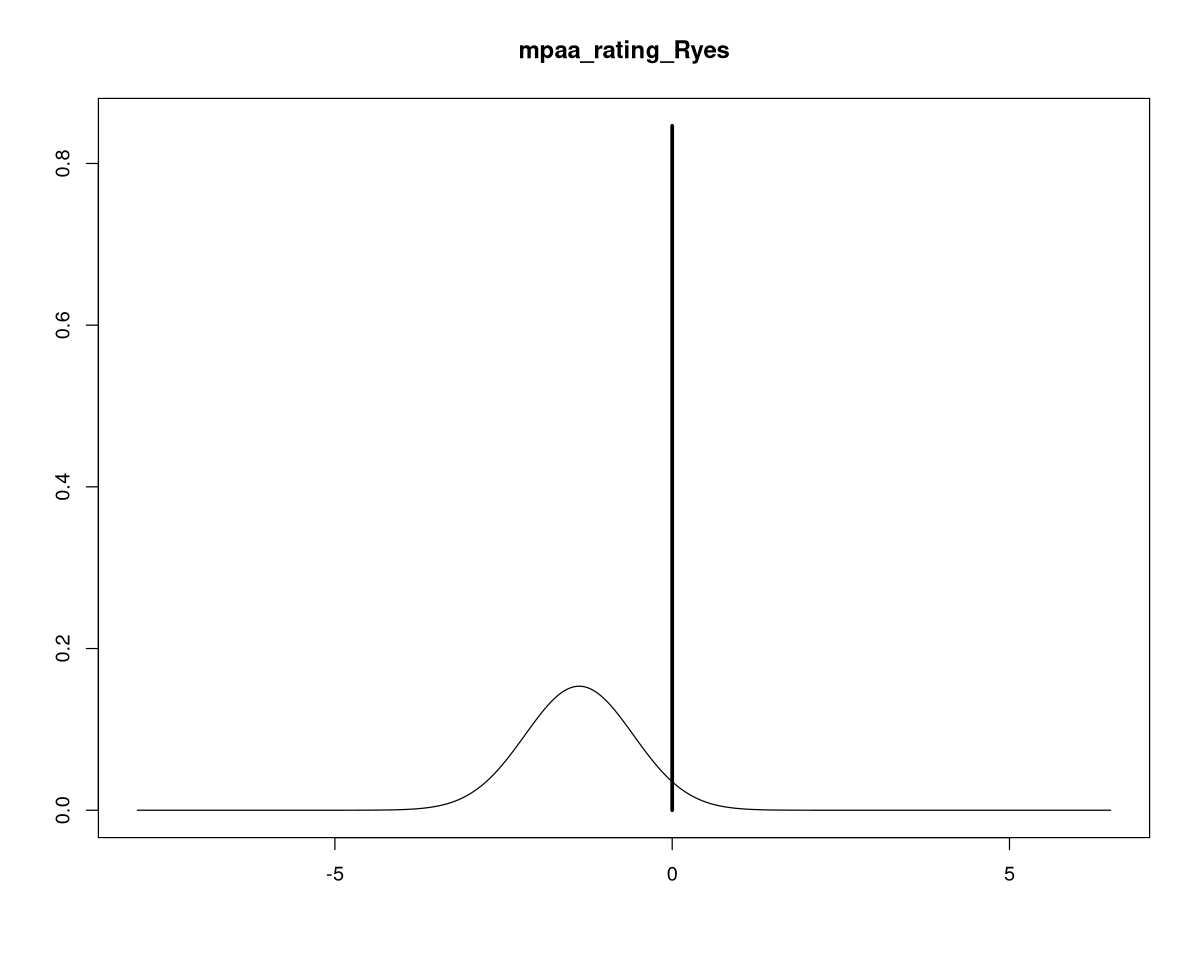

In [28]:
# Obtain the coefficients from the model
coef_movies <- coefficients(movies_model_full)
plot(coef_movies, subset = c(4,5), ask = FALSE)

Runtime is a feature which is included in some of the best performing models. It also has a probability close to 0.5. The reason to exclude it from the final model it's based on the parsimonious concept, where the less predictors with the highest predictive power shall always be used.

MPAA_rating as it can be seen has a quite small posterior probability, looking at the distribution plot, is understandable the reason to reject this coefficient.

## Part 5: Prediction
Finally, let's pick some movies from 2006 outside the dataset to test the model predictability. We'll later determine uncertainty of the inference, but let's first check if the movies are included or not in the dataset.

In [29]:
any(movies_ext=="Zootopia")
any(movies_ext=="The Davinci Code")
any(movies_ext=="The Illusionist")
any(movies_ext=="The Dish")

[1] NA

[1] NA

[1] NA

[1] TRUE

We've chosen `Zootopia`, `The Davinci Code` and `The Illusionist` to perform predictions. As a positive test, we have confirmed that the query is valid, looking for a movie we know it is already included in the dataset: `The Dish`.

Let's now make predictions for these movies, we'll create some dataframes with the movie features first. The inputs have been taken from [imdb.com](https://www.imdb.com/title/tt2948356/) and [Rotten Tomatoes](https://www.rottentomatoes.com/m/zootopia). 

In [30]:
zootopia <- data.frame(
    imdb_rating=8.0,
    critics_score=98,
    feature_film="no",
    drama="no",
    runtime=123,
    mpaa_rating_R="no",
    thtr_rel_year=1900,
    oscar_season="no",
    summer_season="no",
    imdb_num_votes=1000,
    best_pic_nom="no",
    best_pic_win="no",
    best_actor_win="no",
    best_actress_win="no",
    best_dir_win="no",
    top200_box="no"
)

zootopia_pred <- predict(movies_model_full, zootopia, estimator = "HPM", se.fit=TRUE)
confint(zootopia_pred)

         2.5%    97.5%     pred
[1,] 67.52067 107.3632 87.44193
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [31]:
zootopia_pred <- predict(
  movies_model_BIC,
  zootopia
)
zootopia_pred

1 
87.47172

Audience in [Rotten Tomatoes](https://www.rottentomatoes.com/m/zootopia) has ranked the movie with a score of 92%. The estimate is close to this value, falls inside the 95% credible interval, with a `predicted` (fit) value of 87%.


Results using the HPM and the BIC model are significantly close between each other. We've also provided the credible interval for the fit. We'll repeat this process for the other two movies. The BIC model fit estimation will also be provided as reference, for comparison purposes.

In [32]:
davinci_code <- data.frame(
    imdb_rating=6.6,
    critics_score=26,
    feature_film="no",
    drama="no",
    runtime=123,
    mpaa_rating_R="no",
    thtr_rel_year=1900,
    oscar_season="no",
    summer_season="no",
    imdb_num_votes=1000,
    best_pic_nom="no",
    best_pic_win="no",
    best_actor_win="no",
    best_actress_win="no",
    best_dir_win="no",
    top200_box="no"
)

davinci_code_pred <- predict(movies_model_full, davinci_code, estimator = "HPM", se.fit=TRUE)
confint(davinci_code_pred)

         2.5%    97.5%     pred
[1,] 41.54083 81.42046 61.48065
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [33]:
predict(
  movies_model_BIC,
  davinci_code
)

1 
61.47931

Based on the [Rotten Tomatoes](https://www.rottentomatoes.com/m/da_vinci_code) audience, the movie ranked with 57%, which is actually pretty close to what is predicted and also falls inside the credible interval. The difference with the predicted value is 4%.

In [34]:
the_illusionist <- data.frame(
    imdb_rating=7.6,
    critics_score=73,
    feature_film="no",
    drama="no",
    runtime=123,
    mpaa_rating_R="no",
    thtr_rel_year=1900,
    oscar_season="no",
    summer_season="no",
    imdb_num_votes=1000,
    best_pic_nom="no",
    best_pic_win="no",
    best_actor_win="no",
    best_actress_win="no",
    best_dir_win="no",
    top200_box="no"
)

the_illusionist_pred <- predict(movies_model_full, the_illusionist, estimator = "HPM", se.fit=TRUE)
confint(the_illusionist_pred)

         2.5%    97.5%     pred
[1,] 59.78035 99.59007 79.68521
attr(,"Probability")
[1] 0.95
attr(,"class")
[1] "confint.bas"

In [35]:
predict(
  movies_model_BIC,
  the_illusionist
)

1 
79.70571

Based on the [Rotten Tomatoes](https://www.rottentomatoes.com/m/illusionist) audience, the movie ranked with 83%, which is actually pretty close to what is predicted and also falls inside the confidence interval. The difference with the predicted value is about 3%.

## Part 6: Conclusion

The EDA analysis revealed several candidates for a MLR model. Among the candidates, the interesting variables found were: `imdb_rating` & `critics_score`, between the numerical ones. We also found highly correlation between them indicating high collinearity. None of the feature engineered parameters impacted in the model prediction and hence, were discarded during the MLR model construction.

During the analysis and posterior modeling, several methods were used to determined the best performer model, such as BIC, BMA and HPM. Although while evaluating them, not significant differences were observed for the predicted values. Indeed, the methods used coincide in the features selected: `imdb_rating` and `critics_score`. 

The model estimations were good enough to reach the true `audience_score` values relatively close. However, from the previous specialization module, performing MLR using a frequentist approach and using a backwards elimination model selection technique, the estimated error was smaller. The frequentist model relied on more predictors and we manually avoided to use collinear variables.

The feature selection techniques implemented using a Bayesian approach, have totally omitted the collinear issue among variables. This may result in a higher biased model and a reduced predictability power. Despite this effect, the predicted values were very close to the true ones. Finally, it's important to mention that the model relies heavily in values that comes **after** the movie is released. This cannot give **any** predictive information before the movie is ranked, besides the population who ranks it. Considering these factors, the usefulness of the model is quite limited.

## Acronyms

BIC: Bayesian Information Criteria

BMA: Bayesian Model Averaging 

BF: Bayes Factor

MLR: Multiple Linear Regression

HPM: Highest Performance Model

## References

- [Rotten Tomatoes](https://www.rottentomatoes.com/)
- [IMDb](https://www.imdb.com/)